
# Analiza meteoroloških podatkov (vir : ARSO)
## Uvoz podatkov

Podatki so že prej bili naloženi s programoma <TT>prenos-identifikatorjev.py</TT> in <TT>podatki-posameznih-postaj.py</TT>, ki pa ju lahko poženemo tudi iz tega programa

Datoteka <TT>slovar.csv</TT> vsebuje povezavo med imenom postaje in njenim identifikatorjem. 

V <i>/postaje/</i> so datoteke s podatki posameznih postaj po imenih <TT>HXXXX_t_30.html.csv</TT>, kjer XXXX predstavlja identifikacijsko številko postaje.

In [38]:
%run prenos-identifikatorjev.py
#%run podatki-posameznih-postaj.py #zakomentirana vrstica, saj prenos podatkov posameznih postaj traja nekaj minut
#postaj je namreč 180 in vsaka vsebuje 1439 vrstic

In [443]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
import IPython
from ipywidgets import interact
import ipywidgets as widgets
import scipy
import pandas as pd
import random

pd.options.display.max_rows = 30 #Koliko vrstic naenkrat prikaže pandas
pd.options.display.min_rows = 16
%matplotlib inline

vdstj = "Vodostaj [cm]" #da mi ni treba pisati imen z superskripti ves čas, imena so samo brez samoglasnikov, torej so smiselna
prtk = "Pretok [m³/s]"

In [57]:
slovar=[*csv.DictReader(open('slovar.csv'))] #odprem in shranim slovar od prej kot slovar tukaj

In [59]:
slovarpd = pd.read_csv("slovar.csv", encoding='mbcs', index_col="Ime") #če pustim encoding prazen, torej na utf-8 mi da error
slovarpd

,Reka,ID
Ime,,
Gornja Radgona I,Mura,H1060
Petanjci,Mura,H1070
Cankova,Kučnica,H1100
Pristava,Ščavnica,H1140
Nuskova,Ledava,H1165
Polana I,Ledava,H1220
Čentiba,Ledava,H1260
Martjanci,Martjanski potok,H1300
...,...,...


Zdaj lahko izberemo naključno vrsico iz slovarja in analiziramo podatke te postaje

In [485]:
izbrana_postaja = slovarpd.sample()
izbran_id = izbrana_postaja.iat[0,1]

while izbrana_postaja.iat[0,0] == "Jadransko morje":
    izbrana_postaja = slovarpd.sample() # Morje ni reka in torej nima pretoka
    izbran_id = izbrana_postaja.iat[0,1]

izbrano_ime = slovarpd.index[slovarpd["ID"] == izbran_id].tolist()[0]
izbrana_reka = slovarpd.loc[slovarpd["ID"] == izbran_id].iat[0, 0]


In [279]:
izbrani_podatki = pd.read_csv("postaje/" + izbran_id + ".csv", ).replace("-", -1) #nekateri podatki včasih manjkajo in potem jih nadomestim z -1, da je podatek numeričen
izbrani_podatki

,Datum,Vodostaj [cm],Pretok [m³/s],Temperatura vode [°C]
0,31.07.2023 01:30,33,4.65,10.5
1,31.07.2023 02:00,34,4.83,10.5
2,31.07.2023 02:30,35,5.02,10.5
3,31.07.2023 03:00,35,5.02,10.5
4,31.07.2023 03:30,36,5.20,10.5
5,31.07.2023 04:00,36,5.20,10.5
6,31.07.2023 04:30,37,5.40,10.5
7,31.07.2023 05:00,37,5.40,10.5
...,...,...,...,...
1431,29.08.2023 21:00,30,4.14,10.4


# Nihanje temperature reke
Najprej prikažimo nihanje temperature v reki iz katere bi moralo biti razvidno predvsem kdaj je dan in kdaj noč.

<Axes: title={'center': 'Temperatura reke Kamniška Bistrica skozi čas pri postaji Kamnik I'}, xlabel='Datum'>

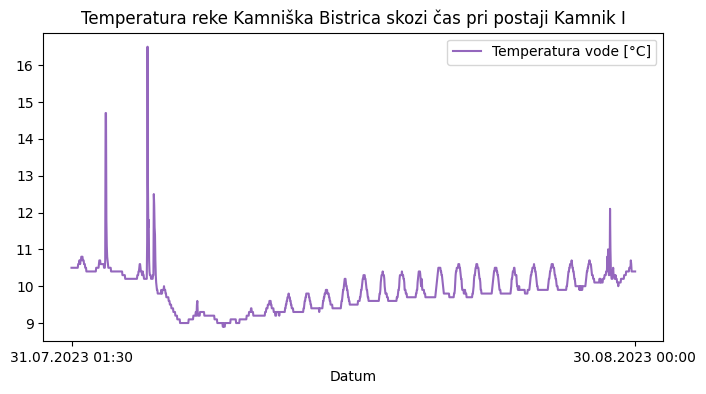

In [489]:
izbrani_podatki.plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, 1437])

Osredotočimo se sedaj na manjši izbor podatkov, da lahko bolj točno vidimo kdaj je dan in kdaj noč

<Axes: title={'center': 'Temperatura reke Kamniška Bistrica skozi čas pri postaji Kamnik I'}, xlabel='Datum'>

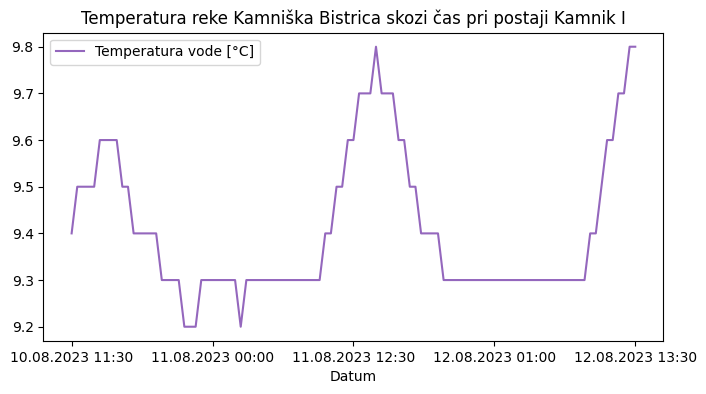

In [490]:
izbrani_podatki.iloc[500:601].plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, 25, 50, 75, 100])

Vidimo, da so dnevna nihanja temperature precej očitna, da pa pričakovano vrh temperatura doseže okoli dveh ali treh popoldne. Za boljši pogled po dnevih lahko uporabimo še interaktiven prikaz.

In [491]:
%matplotlib widget
def interactive_temp(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

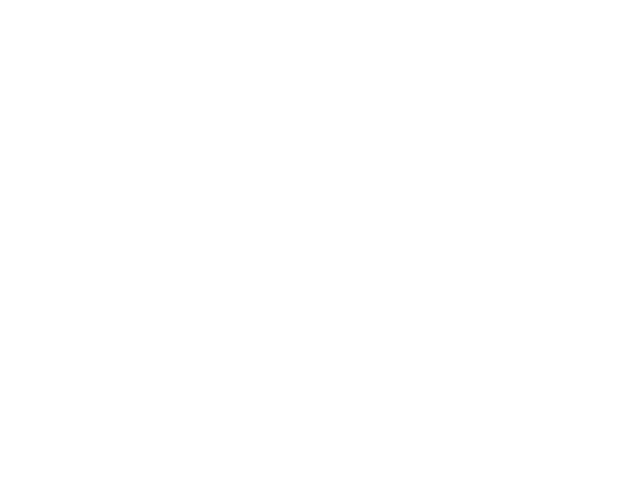

In [492]:
interact(interactive_temp, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

In [456]:
plt.close()
%matplotlib inline

# Pretok in vodostaj reke
Osredotočimo se zdaj  na spreminjanje pretoka in vodostaja čez čas.

<Axes: title={'center': 'Vodostaj skozi čas'}, xlabel='Datum'>

<Figure size 576x432 with 0 Axes>

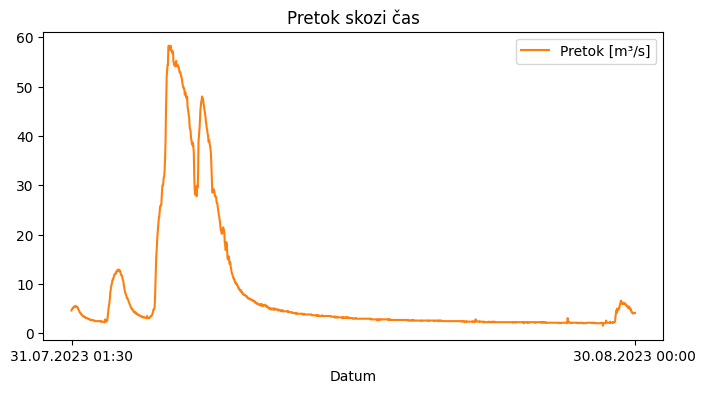

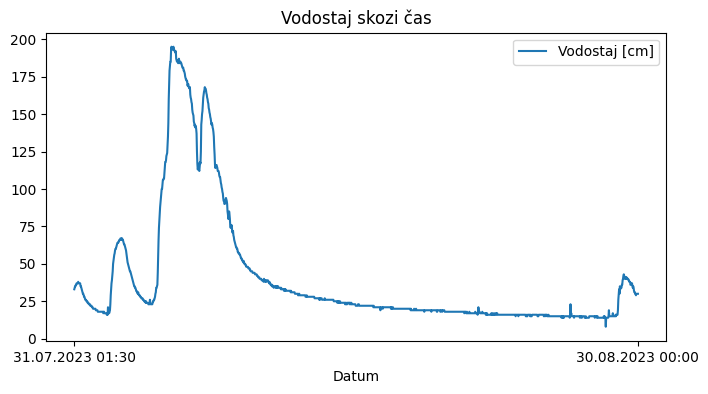

In [457]:
izbrani_podatki.plot(x='Datum', y=prtk, color='C1', title='Pretok skozi čas', figsize=(8, 4), xticks= [0, 1437])
izbrani_podatki.plot(x='Datum', y=vdstj, title='Vodostaj skozi čas', figsize=(8, 4), xticks = [0, 1437])


Za bolj podroben pogled lahko tudi tukaj po enakem principu naredimo interaktiven pogled

In [503]:
%matplotlib widget
def interactive_pretok(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y=prtk, color='C4', title="Pretok reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

In [504]:
interact(interactive_pretok, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

In [501]:
plt.close()
%matplotlib inline

In [502]:
%matplotlib widget
def interactive_vodostaj(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y=vdstj, color='C4', title="Vodostaj reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

In [505]:
interact(interactive_vodostaj, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

In [506]:
plt.close()
%matplotlib inline

# Analiza rečne struge

Vidimo, da sta pretok in vodostaj zelo korelirana, kar je seveda za pričakovati, vprašanje je pa, v kakšni korelaciji sta točno.

Velja namreč $$\dot{V(t, h(t))} = \int_A v(r,t) dr = v \int_0 ^{h(t)} w(x) dx,$$

kjer je $\dot{V}$ pretok vode, $A$ presek vode v rečni strugi, $v$ hitrost vode, $h(t)$ vodostaj (višina vode v reki) ob času $t$ in $w(x)$ širina rečne struge na višini $x$. Predpostavili smo, da je hitrost ves čas konstantna, kar pa sicer ni čisto res, je pa dosti blizu in, ker nimamo podatkov o hitrosti, ne moremo narediti česa drugega. Za enostavno oceno lahko vzamemo $v = 3 m/s$. 

Mi imamo podatke $\dot{V(t)}$ in $h(t),$ iz tega bi torej lahko poskusili dobiti $w(x).$ $w(x)$ bi dobili kot odvod pretoka po višini z uporabo scipy ali numpy.

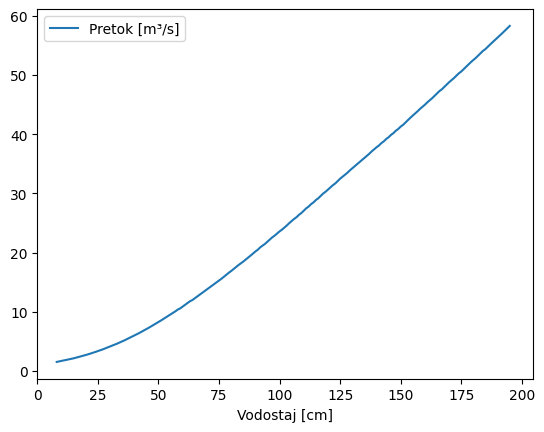

In [458]:
pretok_vodostaj = izbrani_podatki[[vdstj, prtk]].sort_values([vdstj, prtk])
pretok_vodostaj = pretok_vodostaj.drop_duplicates() # da imamo manjši seznam brez nepotrebnih ponovitev
pretok_vodostaj.plot(x = vdstj, y = prtk, xlim = [0, pretok_vodostaj[vdstj].max()*1.05])
plt.show() #da se izognem napisu <Axes: xlabel='Vodostaj [cm]'> na vrhu

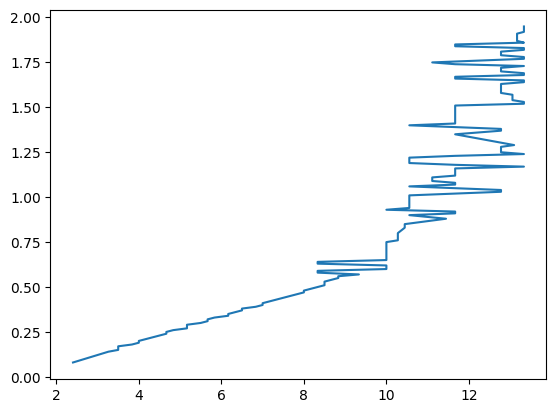

In [427]:
pretoknp = pretok_vodostaj[prtk].to_numpy()
vodostajnp = pretok_vodostaj[vdstj].to_numpy()/100 #pretvorimo centimetre v metre

#pretoknp = np.insert(pretoknp, 0, 0, axis=0) 
#vodostajnp = np.insert(vodostajnp, 0, 0, axis=0) #pretok pri višini 0 mora biti 0

širina = np.gradient(pretoknp, vodostajnp, edge_order = 2)/3 # delimo s hitrostjo)
plt.plot(širina, vodostajnp)
plt.show()

Ker izgleda v večini primerov širina reke zelo nenaravna, tudi zato ker naša predpostavka konstantne hitrosti ne drži zares bi želeli širino prikazati kot neko bolj gladko krivuljo, pri čemer si bomo pomagali s scipy

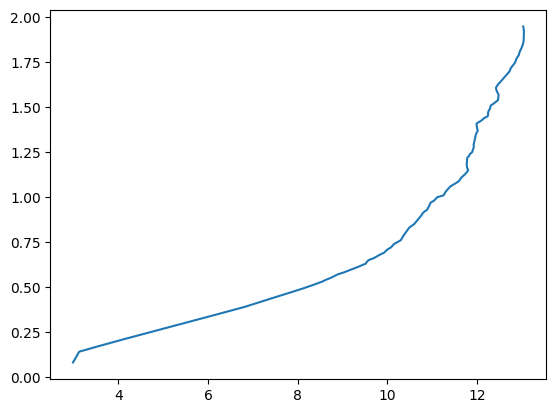

In [428]:
filtrirana_širina = scipy.signal.savgol_filter(širina, 51, 3)

plt.plot(filtrirana_širina, vodostajnp)
plt.show()

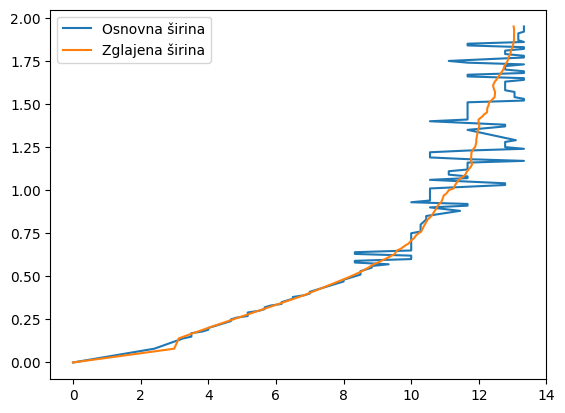

In [429]:
vodostajnp = np.insert(vodostajnp, 0, 0, axis = 0)
širina = np.insert(širina, 0, 0, axis = 0)
filtrirana_širina = np.insert(filtrirana_širina, 0, 0, axis = 0) #želimo, da je pri višini 0 tudi širina 0, razlog, da sem to vključil šele zdaj je, da se drugače pri gradientu zgodijo čudne stvari

plt.plot(širina, vodostajnp, label = "Osnovna širina")
plt.plot(filtrirana_širina, vodostajnp, label = "Zglajena širina")
plt.legend()
plt.show()

Zdaj smo prikazali širino v odvisnosti od višine, vendar ker si rečno strugo po navadi predstavljamo kot simetrično lahko izrišemo tudi takšno:

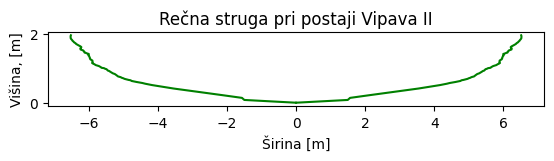

In [430]:
ax = plt.subplot()
ax.plot(filtrirana_širina/2, vodostajnp, color = "green")
ax.plot(-filtrirana_širina/2, vodostajnp, color = "green")
ax.set_aspect('equal') #da izgleda struga bolj naravna, imamo isto skalo na višini in širini
plt.xlabel("Širina [m]")
plt.ylabel("Višina, [m]")
plt.title("Rečna struga pri postaji " + izbrano_ime)
plt.show()

Združimo to zdaj skupaj v funkcijo, ki ji povemo samo identifikator in nam izriše pretok skozi čas, vodostaj skozi čas in zglajeno rečno strugo

In [477]:
def izris(id):
    """
    Funkcija ki sprejme identifikacijsko številko postaje in izriše grafe pretoka, vodostaja in preseka struge
    """

    imeizris = slovarpd.index[slovarpd["ID"] == id].tolist()[0]
    rekaizris = slovarpd.loc[slovarpd["ID"] == id].iat[0, 0]
    
    podatkipd = pd.read_csv("postaje/" + id + ".csv", ).replace("-", -1)
    podatkipd.plot(x='Datum', y=prtk, color='C1', title="Pretok reke " + rekaizris + " skozi čas na postaji " + imeizris, figsize=(8, 4), xticks= [0, 1437])
    podatkipd.plot(x='Datum', y=vdstj, title="Vodostaj reke " + rekaizris + " skozi čas na postaji " + imeizris, figsize=(8, 4), xticks= [0, 1437])
    
    pvizris = izbrani_podatki[[vdstj, prtk]].sort_values([vdstj, prtk]).drop_duplicates()

    pretokizris = pvizris[prtk].to_numpy()
    vodostajizris = pvizris[vdstj].to_numpy()/100
    širinaizris = scipy.signal.savgol_filter(np.gradient(pretokizris, vodostajizris, edge_order = 2)/3, 51, 3)/2

    vodostajizris = np.insert(vodostajizris, 0, 0, axis = 0)
    širinaizris = np.insert(širinaizris, 0, 0, axis = 0)

    fig, ax = plt.subplots()
    
    ax.plot(širinaizris, vodostajizris, color = "green")
    ax.plot(-širinaizris, vodostajizris, color = "green")
    ax.set_aspect('equal') #da izgleda struga bolj naravna, imamo isto skalo na višini in širini
    plt.xlabel("Širina [m]")
    plt.ylabel("Višina, [m]")
    plt.title("Rečna struga reke " + rekaizris + " pri postaji " + imeizris)
    plt.show()
    
    
    

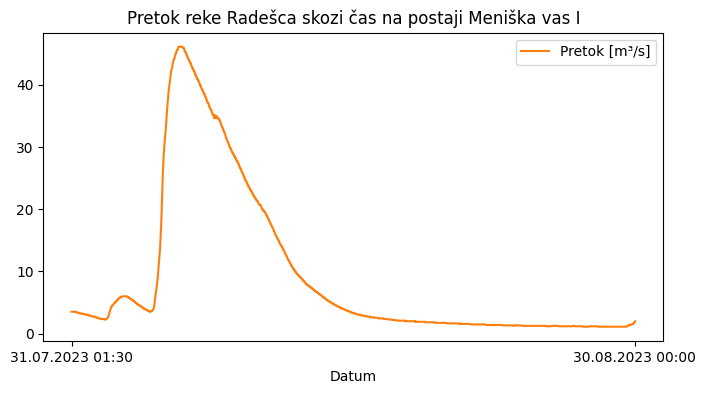

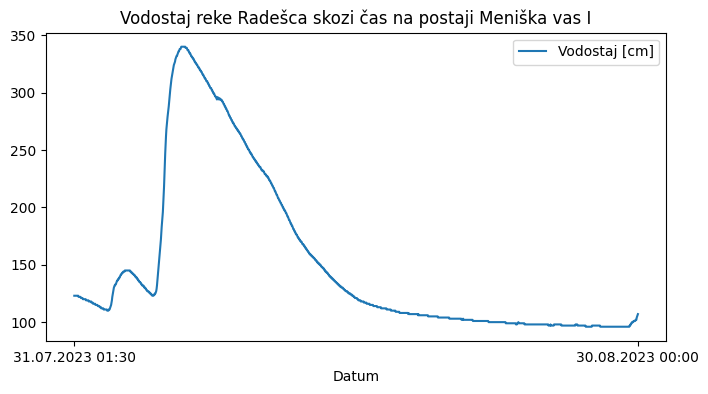

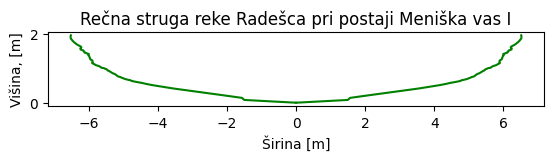

In [508]:
izris(random.choice(slovar)["ID"])

In [511]:
plt.close()
%matplotlib inline

In [353]:
len(slovar)

180

In [354]:
def spremeni_v_float(seznam):
    """
    Funkcija, ki sprejme 2 dimenzionalen seznam (n,4) [datum, višina, pretok, temperatura] in vrne številčni 2d array [višina, pretok]

    Vsak "-" v drugem in tretjem stolpcu spremeni v -1, da lahko potem s seznamom upravljamo kot s števili
    """
    for indeks, i in enumerate(seznam):
        for jndeks, j in enumerate(i):
            if j=='-':
                seznam[indeks, jndeks]="-1"
    #print(list(np.asfarray(seznam[1])))
    novseznam = np.array([np.asfarray(seznam[1]), np.asfarray(seznam[2])])
    
                
    #seznam[1::, 1] = np.asfarray(seznam[1::, 1]) ni hotelo delati iz nekega razloga, zato grem na loope
    #seznam[1::, 2] = np.asfarray(seznam[1::, 2])
    #seznam[1::, 3] = np.asfarray(seznam[1::, 3])

    return novseznam 

In [355]:
def dobi_podatke(ID):
    """
    Funkcija, ki iz ID-ja pridobi tabelo za uporabo v spremeni_v_float
    """

    arry = np.loadtxt("postaje/" + ID + ".csv",
                 delimiter=",", dtype=str)

    arry = np.transpose(np.delete(arry, 0, 0))
    return arry

In [356]:
arr = dobi_podatke(slovar[3]["ID"])
arr = spremeni_v_float(arr)
n = len(arr[0])

In [357]:
arr

array([[ 81.  ,  80.  ,  80.  , ..., 156.  , 152.  , 147.  ],
       [  1.91,   1.85,   1.85, ...,   9.65,   9.12,   8.5 ]])

In [358]:
order = np.argsort(arr[1::,1])
xs = np.array(arr[1::,1])[order][100:120]
ys = np.array(arr[1::,2])[order]
xs


array([], dtype=float64)

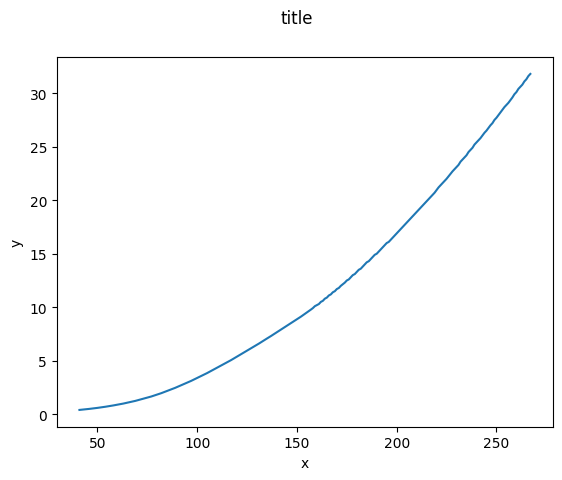

In [359]:
order = np.argsort(arr[0])
xs = np.array(arr[0])[order]
ys = np.array(arr[1])[order]

fig = plt.figure()
ax = plt.subplot()

fig.suptitle('title')
plt.xlabel('x')
plt.ylabel('y')

ax.plot(xs, ys, label='desc' )
plt.show()

[ 0.00052755 -0.02281949  0.39230224]


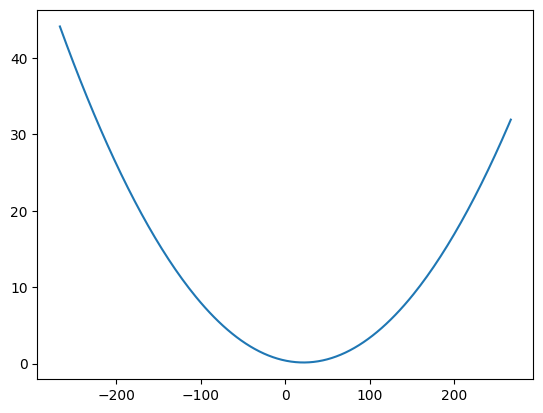

In [360]:
fit = np.poly1d(np.polyfit(xs, ys, 2))
print(np.polyfit(xs, ys, 2))
x = np.linspace(-xs[-1], xs[-1], 200)
plt.plot(x, fit(x))

In [361]:
np.asfarray(arr[1::, 1]).copy()

array([1.85])

In [362]:
arr[1::, 1]

array([1.85])

In [363]:
n

1439

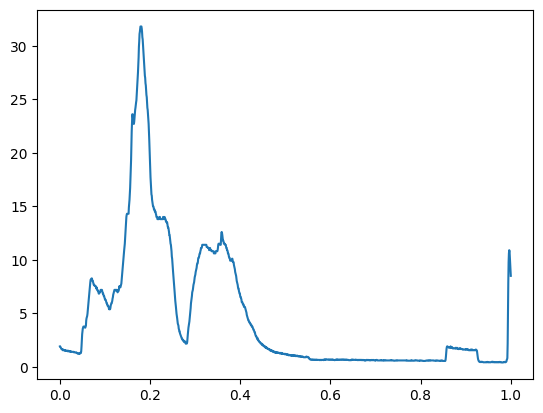

In [364]:
plt.plot(np.linspace(0,1, n), arr[1])

{'Ime': 'Celje II', 'Reka': 'Savinja', 'ID': 'H6140_t_30.html'}
{'Ime': 'Celje II', 'Reka': 'Voglajna', 'ID': 'H6720_t_30.html'}
'Ime': 'Laško', 'Reka': 'Savinja', 'ID': 'H6200_t_30.html'}

In [374]:
savinja = ['H6140', 'H6720', 'H6200'] #savinja v celju, voglajna v Celju, savinja v laškem

In [375]:
pretoki_savinje = [spremeni_v_float(dobi_podatke(i)) for i in savinja]

In [376]:
%matplotlib inline
#%matplotlib inline

In [377]:
#%matplotlib notebook

In [378]:
#%matplotlib widget

In [379]:
#%matplotlib ipympl

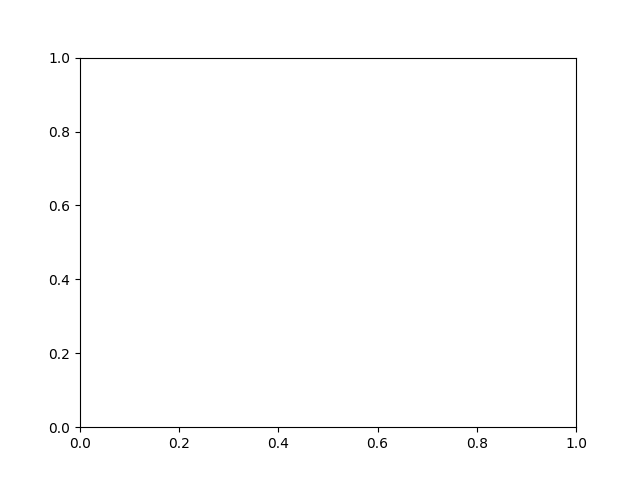

In [384]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1, 200)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#line, = ax.plot(x, pretoki_savinje[0][1][500:500+200])



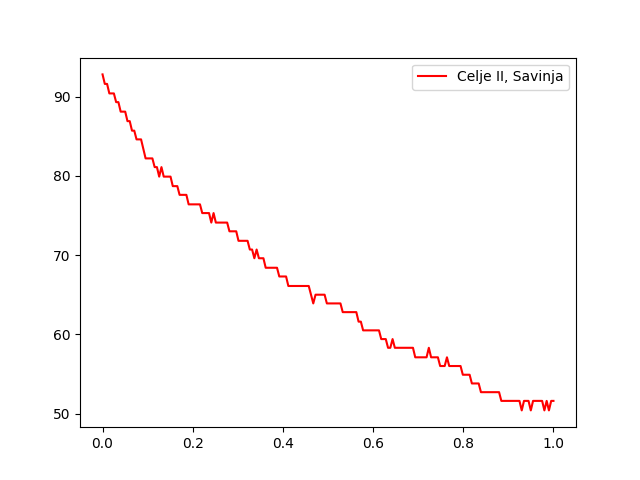

In [385]:
k=500
dolz=200
plt.plot(np.linspace(0,1, dolz), pretoki_savinje[0][1][k:k+dolz], color = "red", label = "Celje II, Savinja")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[1][1][k:k+dolz], color = "green", label = "Celje II, Voglajna")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[2][1][k:k+dolz], color = "aqua", label = "Laško, Savinja")
plt.legend()
plt.show()

In [386]:
plt.close()

In [387]:
c = pretoki_savinje[2][1]-pretoki_savinje[0][1] - pretoki_savinje[1][1]
plt.plot(np.linspace(0,1, n), c)


In [388]:
def casovna_razlika(prvi, drugi):
    """
    Funkcija ki pogleda dva enako velika np.arraya in poskusi ugotoviti zamik med njima
    """
    konst = 0.0 
    zamik = 0
    n = len(prvi)
    if n!=len(drugi):
        RaiseException("Seznama se morata ujemati po dolžini")
        print(hmm)
    
    def kvadratna_razlika(zamik):
        """
        Izračun razlike
        prvi in drugi sta že definirana v casovna_razlika, funkcija se ne more uporabljati izven tega
        """
        if zamik>=0:
            izracun = np.sum((prvi[0:n-zamik:]-drugi[zamik::])**2/(n-zamik)**2)
            #pogledamo kvadrat razlike, ga normaliziramo, da se zmanjša vpliv tega, da je manj podatkov pri večjem zamiku, odštejemo konstanto, za katero 
        else:
            izracun = np.sum((prvi[-zamik::]-drugi[0:n+zamik:])**2/(n+zamik)**2)
            #zamik je lahko v eno ali drugo smer
        return izracun

    seznam_razlik = [kvadratna_razlika(i) for i in np.arange(-10, 11)]
    
    
    return seznam_razlik

In [389]:
casovna_razlika(pretoki_savinje[0][1], pretoki_savinje[1][1])

[28.890215371643865,
 28.82458031939312,
 28.758239985099337,
 28.691310395336735,
 28.624150706006702,
 28.557063975754684,
 28.49044476204737,
 28.42460959990563,
 28.359708715930843,
 28.296100775942,
 28.23389105858636,
 28.247459401060716,
 28.262084002339503,
 28.2779898541227,
 28.295140221552767,
 28.313578636202582,
 28.332942785779224,
 28.352952808475372,
 28.373438535076605,
 28.394560915705902,
 28.416320385451126]

In [390]:
len(pretoki_savinje[1][1])

1439

In [391]:
len(pretoki_savinje[1][1][10::])

1429

In [392]:
len(pretoki_savinje[1][1][0:n-10:])

1429

In [393]:
(pretoki_savinje[1][1][10::]-pretoki_savinje[1][1][0:n-10:])**2

array([3.7636, 3.5721, 2.3104, ..., 8.8209, 3.3856, 1.1236])

In [394]:
np.arange(-10, 11)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [395]:
def slika(k=1, dolz = 200, ):
    n = len(pretoki_savinje[0][1])
    plt.clf()
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[0][1][k:min(k+dolz, n)], label = "Celje II, Savinja")
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[1][1][k:min(k+dolz, n)], label = "Celje II, Voglajna")
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[2][1][k:min(k+dolz, n)], label = "Laško - Savinja")
    #plt.ylim(-5, 5)
    plt.show()

In [396]:
interact(slika, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=200, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=200, descr…

In [29]:
plt.close()

In [29]:
plt.close()

In [13]:
import pandas as pd
knjige = pd.read_csv('postaje/H6200_t_30.html.csv', index_col='Datum')
knjige.title()

AttributeError: 'DataFrame' object has no attribute 'title'